# V = 3, C = 4, Mixture of four independent trivariate Gaussians

Requires RainDancesVI package https://prasanthcakewalk.gitlab.io/raindancesvi/ (tested with version 0.1.0)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as klayers

import raindancesvi as rd6
from raindancesvi import inclass_utils

In [3]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'text.usetex': True, 'text.latex.preview': True})

def figname(string):
    fig_dir = 'figures/V3_C4_four_gaussians'
    fig_name_prefix = 'four_gaussians_'
    return f'{fig_dir}/{fig_name_prefix}{string}'

## Data generation & true classifier definition:

In [4]:
rng_seed = 0
rng = np.random.Generator(np.random.PCG64(rng_seed))

x_input_shape, y_input_shape, z_input_shape = 1, 1, 1
comp_1_params = {'x_args': {'loc': -1, 'scale': 1.5}, 'y_args': {'loc': -1, 'scale': 1.5}, 'z_args': {'loc': -1, 'scale': 1.5}}
comp_2_params = {'x_args': {'loc': 1, 'scale': 1.5}, 'y_args': {'loc': 1, 'scale': 1.5}, 'z_args': {'loc': 0, 'scale': 1.5}}
comp_3_params = {'x_args': {'loc': -1.5, 'scale': 1.5}, 'y_args': {'loc': 1.5, 'scale': 1.5}, 'z_args': {'loc': 1, 'scale': 1.5}}
comp_4_params = {'x_args': {'loc': 1.5, 'scale': 1.5}, 'y_args': {'loc': -1.5, 'scale': 1.5}, 'z_args': {'loc': 2, 'scale': 2.5}}
w_1, w_2, w_3, w_4 = 0.22, 0.28, 0.18, 0.32

comp_1_x_pdf = lambda x: scipy.stats.norm.pdf(x, **comp_1_params['x_args'])
comp_2_x_pdf = lambda x: scipy.stats.norm.pdf(x, **comp_2_params['x_args'])
comp_3_x_pdf = lambda x: scipy.stats.norm.pdf(x, **comp_3_params['x_args'])
comp_4_x_pdf = lambda x: scipy.stats.norm.pdf(x, **comp_4_params['x_args'])

comp_1_y_pdf = lambda y: scipy.stats.norm.pdf(y, **comp_1_params['y_args'])
comp_2_y_pdf = lambda y: scipy.stats.norm.pdf(y, **comp_2_params['y_args'])
comp_3_y_pdf = lambda y: scipy.stats.norm.pdf(y, **comp_3_params['y_args'])
comp_4_y_pdf = lambda y: scipy.stats.norm.pdf(y, **comp_4_params['y_args'])

comp_1_z_pdf = lambda z: scipy.stats.norm.pdf(z, **comp_1_params['z_args'])
comp_2_z_pdf = lambda z: scipy.stats.norm.pdf(z, **comp_2_params['z_args'])
comp_3_z_pdf = lambda z: scipy.stats.norm.pdf(z, **comp_3_params['z_args'])
comp_4_z_pdf = lambda z: scipy.stats.norm.pdf(z, **comp_4_params['z_args'])

x_pdf = lambda x: w_1 * comp_1_x_pdf(x) + w_2 * comp_2_x_pdf(x) + w_3 * comp_3_x_pdf(x) + w_4 * comp_4_x_pdf(x)
y_pdf = lambda y: w_1 * comp_1_y_pdf(y) + w_2 * comp_2_y_pdf(y) + w_3 * comp_3_y_pdf(y) + w_4 * comp_4_y_pdf(y)
z_pdf = lambda z: w_1 * comp_1_z_pdf(z) + w_2 * comp_2_z_pdf(z) + w_3 * comp_3_z_pdf(z) + w_4 * comp_4_z_pdf(z)

xy_pdf = lambda x, y: w_1 * comp_1_x_pdf(x) * comp_1_y_pdf(y) + w_2 * comp_2_x_pdf(x) * comp_2_y_pdf(y) + \
                        w_3 * comp_3_x_pdf(x) * comp_3_y_pdf(y) + w_4 * comp_4_x_pdf(x) * comp_4_y_pdf(y)

xyz_pdf = lambda x, y, z: w_1 * comp_1_x_pdf(x) * comp_1_y_pdf(y) * comp_1_z_pdf(z) + w_2 * comp_2_x_pdf(x) * comp_2_y_pdf(y) * comp_2_z_pdf(z) + \
                        w_3 * comp_3_x_pdf(x) * comp_3_y_pdf(y) * comp_3_z_pdf(z) + w_4 * comp_4_x_pdf(x) * comp_4_y_pdf(y) * comp_4_z_pdf(z)

# Data generation ######################
N = 10**6
N_1, N_2, N_3, N_4 = rng.multinomial(N, [w_1, w_2, w_3, w_4])

comp_1_x = rng.normal(size=N_1, **comp_1_params['x_args'])
comp_1_y = rng.normal(size=N_1, **comp_1_params['y_args'])
comp_1_z = rng.normal(size=N_1, **comp_1_params['z_args'])

comp_2_x = rng.normal(size=N_2, **comp_2_params['x_args'])
comp_2_y = rng.normal(size=N_2, **comp_2_params['y_args'])
comp_2_z = rng.normal(size=N_2, **comp_2_params['z_args'])

comp_3_x = rng.normal(size=N_3, **comp_3_params['x_args'])
comp_3_y = rng.normal(size=N_3, **comp_3_params['y_args'])
comp_3_z = rng.normal(size=N_3, **comp_3_params['z_args'])

comp_4_x = rng.normal(size=N_4, **comp_4_params['x_args'])
comp_4_y = rng.normal(size=N_4, **comp_4_params['y_args'])
comp_4_z = rng.normal(size=N_4, **comp_4_params['z_args'])

sample_x = np.concatenate([comp_1_x, comp_2_x, comp_3_x, comp_4_x])
sample_y = np.concatenate([comp_1_y, comp_2_y, comp_3_y, comp_4_y])
sample_z = np.concatenate([comp_1_z, comp_2_z, comp_3_z, comp_4_z])

shuffle = rng.permutation(N)
sample_x = sample_x[shuffle]
sample_y = sample_y[shuffle]
sample_z = sample_z[shuffle]
########################################

# True classifier definition ###########
comp_1_classify_x = lambda x: w_1 * comp_1_x_pdf(x) / x_pdf(x)
comp_2_classify_x = lambda x: w_2 * comp_2_x_pdf(x) / x_pdf(x)
comp_3_classify_x = lambda x: w_3 * comp_3_x_pdf(x) / x_pdf(x)
comp_4_classify_x = lambda x: w_4 * comp_4_x_pdf(x) / x_pdf(x)

comp_1_classify_y = lambda y: w_1 * comp_1_y_pdf(y) / y_pdf(y)
comp_2_classify_y = lambda y: w_2 * comp_2_y_pdf(y) / y_pdf(y)
comp_3_classify_y = lambda y: w_3 * comp_3_y_pdf(y) / y_pdf(y)
comp_4_classify_y = lambda y: w_4 * comp_4_y_pdf(y) / y_pdf(y)

comp_1_classify_z = lambda z: w_1 * comp_1_z_pdf(z) / z_pdf(z)
comp_2_classify_z = lambda z: w_2 * comp_2_z_pdf(z) / z_pdf(z)
comp_3_classify_z = lambda z: w_3 * comp_3_z_pdf(z) / z_pdf(z)
comp_4_classify_z = lambda z: w_4 * comp_4_z_pdf(z) / z_pdf(z)

comp_1_classify_xyz = lambda x, y, z: w_1 * comp_1_x_pdf(x) * comp_1_y_pdf(y) * comp_1_z_pdf(z) / xyz_pdf(x, y, z)
comp_2_classify_xyz = lambda x, y, z: w_2 * comp_2_x_pdf(x) * comp_2_y_pdf(y) * comp_2_z_pdf(z) / xyz_pdf(x, y, z)
comp_3_classify_xyz = lambda x, y, z: w_3 * comp_3_x_pdf(x) * comp_3_y_pdf(y) * comp_3_z_pdf(z) / xyz_pdf(x, y, z)
comp_4_classify_xyz = lambda x, y, z: w_4 * comp_4_x_pdf(x) * comp_4_y_pdf(y) * comp_4_z_pdf(z) / xyz_pdf(x, y, z)

def true_classifiers(inputs):
    x, y, z = inputs
    components = 4
    ans = np.zeros((len(x), 3, components))
    ans[:,0,0] = comp_1_classify_x(x)
    ans[:,1,0] = comp_1_classify_y(y)
    ans[:,2,0] = comp_1_classify_z(z)
    
    ans[:,0,1] = comp_2_classify_x(x)
    ans[:,1,1] = comp_2_classify_y(y)
    ans[:,2,1] = comp_2_classify_z(z)
    
    ans[:,0,2] = comp_3_classify_x(x)
    ans[:,1,2] = comp_3_classify_y(y)
    ans[:,2,2] = comp_3_classify_z(z)
    
    ans[:,0,3] = comp_4_classify_x(x)
    ans[:,1,3] = comp_4_classify_y(y)
    ans[:,2,3] = comp_4_classify_z(z)
    
    return ans

def true_aggregate_classifier(inputs):
    x, y, z = inputs
    components = 4
    ans = np.zeros((len(x), components))
    ans[:,0] = comp_1_classify_xyz(x, y, z)
    ans[:,1] = comp_2_classify_xyz(x, y, z)
    ans[:,2] = comp_3_classify_xyz(x, y, z)
    ans[:,3] = comp_4_classify_xyz(x, y, z)
    
    return ans
########################################

## Data visualization:

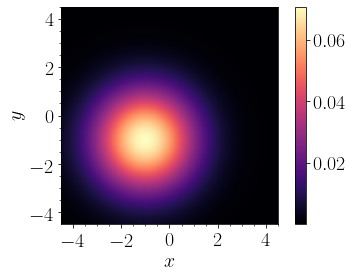

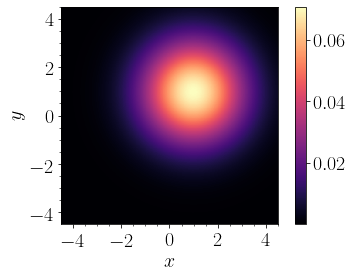

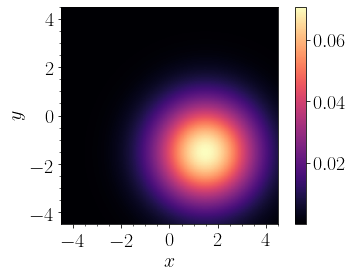

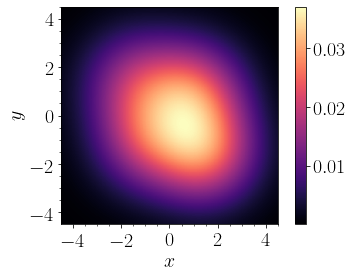

In [5]:
cmap = 'magma'

def plot_format(ax):
    ax.set_aspect('equal')
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(-4.5, 4.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xticks(range(-4, 5, 2))
    ax.set_yticks(range(-4, 5, 2))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(-4.5, 4.5, 500)
y = np.linspace(-4.5, 4.5, 500)
x, y = np.meshgrid(x, y)

fig, ax = plt.subplots()
z = comp_1_x_pdf(x) * comp_1_y_pdf(y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plot_format(ax)
plt.colorbar(_)
plt.savefig(figname('heatmap_comp_1.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = comp_2_x_pdf(x) * comp_2_y_pdf(y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_comp_2.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = comp_3_x_pdf(x) * comp_3_y_pdf(y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_comp_3.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = comp_4_x_pdf(x) * comp_4_y_pdf(y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_comp_4.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = xy_pdf(x, y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_combined.pdf'), bbox_inches='tight')

## Building individual classifier networks for the different variates:

In [6]:
tf.random.set_seed(1)
class_count = 4

model_x = keras.Sequential()
model_x.add(keras.Input(x_input_shape))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(class_count, activation='softmax'))

model_y = keras.Sequential()
model_y.add(keras.Input(y_input_shape))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(class_count, activation='softmax'))

model_z = keras.Sequential()
model_z.add(keras.Input(z_input_shape))
model_z.add(klayers.Dense(32, activation='relu'))
model_z.add(klayers.Dense(32, activation='relu'))
model_z.add(klayers.Dense(32, activation='relu'))
model_z.add(klayers.Dense(class_count, activation='softmax'))

## Making an InClass Net out of the individual classifier networks:

In [7]:
inclass_model = rd6.InClassNet([model_x, model_y, model_z])
inclass_model.summary()

Model: "in_class_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           64          input_1[0][0]                    
_______________________________________________________________________________________

## Compiling and fitting the model:

In [8]:
inclass_model.compile(optimizer='adam', loss=rd6.losses.neg_ctc_cost)

In [9]:
inclass_model.fit(x=[sample_x, sample_y, sample_z], y='dummy', batch_size=500, epochs=15)

Epoch 1/15
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
2000/2000 [==============================] - 9s 4ms/step - loss: -0.0704
Epoch 2/15
2000/2000 [==============================] - 8s 4ms/step - loss: -0.0720
Epoch 3/15
2000/2000 [==============================] - 8s 4ms/step - loss: -0.0721
Epoch 4/15
2000/2000 [==============================] - 9s 5ms/step - loss: -0.0722
Epoch 5/15
2000/2000 [==============================] - 12s 6ms/step - loss: -0.0722
Epoch 6/15
2000/2000 [==============================] - 8s 4ms/step - loss: -0.0722
Epoch 7/15
2000/2000 [==============================] - 9s 5ms/step - loss: -0.0723
Epoch 8/15
2000/2000 [==============================] - 12s 6ms/step - loss: -0.0723
Epoch 9/15
2000/2000 [==============================] - 8s 4ms/step - loss: -0.0723
Epoch 10/15
2000/2000 [==============================] - 8s 4ms/step - loss: -0.0723
Epoch 11/15
2000/2000 [================

## Postprocessing the network outputs:

In [10]:
predictions = inclass_model.predict([sample_x, sample_y, sample_z])
model_postprocess = inclass_utils.postprocess(predictions)

print("model_postprocess is a dict containing the following keys:")
for key in model_postprocess:
    print(f"  * '{key}'")

model_postprocess is a dict containing the following keys:
  * 'pseudo_weights'
  * 'norm_weights'
  * 'balanced_classifier_outputs'
  * 'aggregate_classifier_output'
  * 'unnorm_neg_ctc_cost'
  * 'neg_ctc_cost'


## Learned model vs True model comparison:

In [11]:
print("neg_ctc_cost")
print("  * true classifiers:", inclass_utils.get_neg_ctc_cost(true_classifiers([sample_x, sample_y, sample_z])))
print("  * learned classifiers:", model_postprocess['neg_ctc_cost'])

neg_ctc_cost
  * true classifiers: -0.07301929640208149
  * learned classifiers: -0.07265693


In [12]:
print("Learned pseudo weights:")
print("  * x:", list(model_postprocess['pseudo_weights'][0]))
print("  * y:", list(model_postprocess['pseudo_weights'][1]))
print("  * z:", list(model_postprocess['pseudo_weights'][2]))
print("")
print("Component weights:")
print("  * true:", [w_1, w_2, w_3, w_4])
print("  * learned:", list(model_postprocess['norm_weights']))

Learned pseudo weights:
  * x: [0.31597814, 0.18819153, 0.22989921, 0.26593116]
  * y: [0.3173774, 0.18682337, 0.22543144, 0.27036774]
  * z: [0.32003933, 0.18574229, 0.2274754, 0.26674297]

Component weights:
  * true: [0.22, 0.28, 0.18, 0.32]
  * learned: [0.31780064, 0.18692039, 0.22759956, 0.26767942]


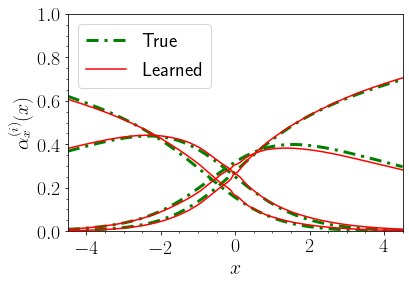

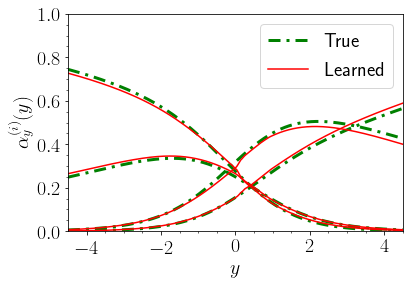

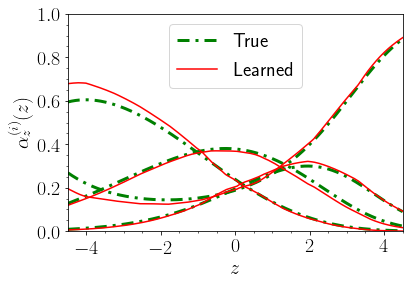

In [13]:
def plot_format(ax):
    ax.set_xticks(range(-4, 5, 2))
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(-4.5, 4.5, 1000)
raw_x_classifier_output = model_x.predict(x)
balanced_x_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_x_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][0], 
                                                                                   weights=model_postprocess['norm_weights'])

y = np.linspace(-4.5, 4.5, 1000)
raw_y_classifier_output = model_y.predict(y)
balanced_y_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_y_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][1], 
                                                                                   weights=model_postprocess['norm_weights'])

z = np.linspace(-4.5, 4.5, 1000)
raw_z_classifier_output = model_z.predict(z)
balanced_z_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_z_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][2], 
                                                                                   weights=model_postprocess['norm_weights'])

fig, ax = plt.subplots()
ax.plot(x, comp_1_classify_x(x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(x, comp_2_classify_x(x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, comp_3_classify_x(x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, comp_4_classify_x(x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, balanced_x_classifier_output[:,0], color='red', label='Learned')
ax.plot(x, balanced_x_classifier_output[:,1], color='red')
ax.plot(x, balanced_x_classifier_output[:,2], color='red')
ax.plot(x, balanced_x_classifier_output[:,3], color='red')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\alpha^{(i)}_x(x)$')
plot_format(ax)
plt.savefig(figname('classifier_x.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(y, comp_1_classify_y(y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(y, comp_2_classify_y(y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, comp_3_classify_y(y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, comp_4_classify_y(y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, balanced_y_classifier_output[:,0], color='red', label='Learned')
ax.plot(y, balanced_y_classifier_output[:,1], color='red')
ax.plot(y, balanced_y_classifier_output[:,2], color='red')
ax.plot(y, balanced_y_classifier_output[:,3], color='red')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$\alpha^{(i)}_y(y)$')
plot_format(ax)
plt.savefig(figname('classifier_y.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(z, comp_1_classify_z(z), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(z, comp_2_classify_z(z), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(z, comp_3_classify_z(z), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(z, comp_4_classify_z(z), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(z, balanced_z_classifier_output[:,0], color='red', label='Learned')
ax.plot(z, balanced_z_classifier_output[:,1], color='red')
ax.plot(z, balanced_z_classifier_output[:,2], color='red')
ax.plot(z, balanced_z_classifier_output[:,3], color='red')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\alpha^{(i)}_z(z)$')
plot_format(ax)
plt.savefig(figname('classifier_z.pdf'), bbox_inches='tight')

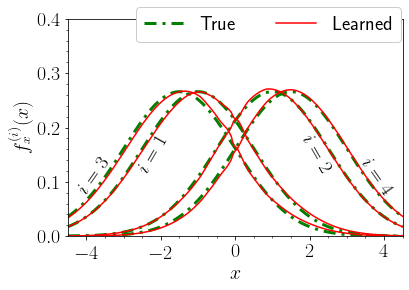

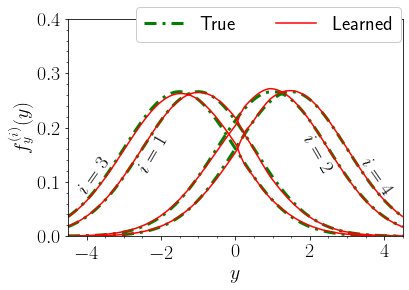

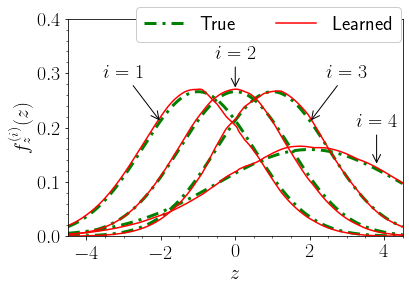

In [14]:
def plot_format(ax):
    ax.set_xticks(range(-4, 5, 2))
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(0, .4)
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.6, 1.1), framealpha=1.)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

fig, ax = plt.subplots()
ax.plot(x, x_pdf(x)*comp_1_classify_x(x)/w_1, color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(x, x_pdf(x)*comp_2_classify_x(x)/w_2, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, x_pdf(x)*comp_3_classify_x(x)/w_3, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, x_pdf(x)*comp_4_classify_x(x)/w_4, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,0]/model_postprocess['norm_weights'][0], color='red', label='Learned')
ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,1]/model_postprocess['norm_weights'][1], color='red')
ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,2]/model_postprocess['norm_weights'][2], color='red')
ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,3]/model_postprocess['norm_weights'][3], color='red')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f^{(i)}_x(x)$')
ax.text(-3.8, .11, r"$i=3$", ha='center', va='center', rotation=55)
ax.text(-2.2, .15, r"$i=1$", ha='center', va='center', rotation=60)
ax.text(3.8, .11, r"$i=4$", ha='center', va='center', rotation=-55)
ax.text(2.2, .15, r"$i=2$", ha='center', va='center', rotation=-60)
plot_format(ax)
plt.savefig(figname('compdist_x.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(y, y_pdf(y)*comp_1_classify_y(y)/w_1, color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(y, y_pdf(y)*comp_2_classify_y(y)/w_2, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, y_pdf(y)*comp_3_classify_y(y)/w_3, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, y_pdf(y)*comp_4_classify_y(y)/w_4, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,0]/model_postprocess['norm_weights'][0], color='red', label='Learned')
ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,1]/model_postprocess['norm_weights'][1], color='red')
ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,2]/model_postprocess['norm_weights'][2], color='red')
ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,3]/model_postprocess['norm_weights'][3], color='red')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$f^{(i)}_y(y)$')
ax.text(-3.8, .11, r"$i=3$", ha='center', va='center', rotation=55)
ax.text(-2.2, .15, r"$i=1$", ha='center', va='center', rotation=60)
ax.text(3.8, .11, r"$i=4$", ha='center', va='center', rotation=-55)
ax.text(2.2, .15, r"$i=2$", ha='center', va='center', rotation=-60)
plot_format(ax)
plt.savefig(figname('compdist_y.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(z, z_pdf(z)*comp_1_classify_z(z)/w_1, color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(z, z_pdf(z)*comp_2_classify_z(z)/w_2, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(z, z_pdf(z)*comp_3_classify_z(z)/w_3, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(z, z_pdf(z)*comp_4_classify_z(z)/w_4, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(z, z_pdf(z)*balanced_z_classifier_output[:,0]/model_postprocess['norm_weights'][0], color='red', label='Learned')
ax.plot(z, z_pdf(z)*balanced_z_classifier_output[:,1]/model_postprocess['norm_weights'][1], color='red')
ax.plot(z, z_pdf(z)*balanced_z_classifier_output[:,2]/model_postprocess['norm_weights'][2], color='red')
ax.plot(z, z_pdf(z)*balanced_z_classifier_output[:,3]/model_postprocess['norm_weights'][3], color='red')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$f^{(i)}_z(z)$')
ax.annotate(r'$i=1$', xy=(-2, .21), xytext=(-3,.3), ha='center', va='center', arrowprops={'arrowstyle':'->'})
ax.annotate(r'$i=2$', xy=(0, .27), xytext=(0,.335), ha='center', va='center', arrowprops={'arrowstyle':'->'})
ax.annotate(r'$i=3$', xy=(2, .21), xytext=(3,.3), ha='center', va='center', arrowprops={'arrowstyle':'->'})
ax.annotate(r'$i=4$', xy=(3.8, .13), xytext=(3.8,.21), ha='center', va='center', arrowprops={'arrowstyle':'->'})
plot_format(ax)
plt.savefig(figname('compdist_z.pdf'), bbox_inches='tight')